In [79]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Edge detection using Canny Edge detection

In [80]:


def apply_edge_detection(img):
    """
    Applies Canny edge detection to a color image.
    Args:
        img (numpy.ndarray): Color image.
    Returns:
        numpy.ndarray: Binary edge image.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply edge detection using the Canny algorithm
    edges = cv2.Canny(gray, 50, 150)

    # Return the binary edge image
    return edges


# Segment Primitives

In image processing, segment primitives are basic geometric shapes or patterns that can be extracted from an image. These primitives are often used as a first step towards object recognition or analysis of the image content.

A segment primitive can be defined as a connected set of pixels in the image that satisfies certain criteria. For example, a horizontal segment primitive might be defined as a set of connected pixels that lie along a straight line and have a relatively long width and short height. Similarly, a vertical segment primitive might be defined as a set of connected pixels that lie along a straight line and have a relatively long height and short width.

Once segment primitives are extracted from an image, they can be used to detect and recognize more complex shapes or objects in the image. 

In [81]:
def extract_segment_primitives(edges, min_segment_length=10):
    """
    Extracts horizontal and vertical segments from binary edge image.

    Args:
        edges (numpy.ndarray): Binary edge image.
        min_segment_length (int): Minimum length of a segment. Defaults to 10.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Tuple of horizontal and vertical segments, each represented
        as a list of tuples in the format (coordinate, start, length).

    """

    # Initialize lists to store horizontal and vertical segments
    horizontal_segments = []
    vertical_segments = []

    # Loop through each row of the edge image to find horizontal segments
    for y in range(edges.shape[0]):
        x = 0
        while x < edges.shape[1]:
            # If there's a white pixel in the edge image, it marks the beginning of a segment
            if edges[y, x] == 255:
                start = x
                # Keep moving to the right to find the end of the segment
                while x < edges.shape[1] and edges[y, x] == 255:
                    x += 1
                length = x - start
                # If the length of the segment is greater than the minimum, store it as a horizontal segment
                if length >= min_segment_length:
                    horizontal_segments.append((y, start, length))
            else:
                x += 1

    # Loop through each column of the edge image to find vertical segments
    for x in range(edges.shape[1]):
        y = 0
        while y < edges.shape[0]:
            # If there's a white pixel in the edge image, it marks the beginning of a segment
            if edges[y, x] == 255:
                start = y
                # Keep moving down to find the end of the segment
                while y < edges.shape[0] and edges[y, x] == 255:
                    y += 1
                length = y - start
                # If the length of the segment is greater than the minimum, store it as a vertical segment
                if length >= min_segment_length:
                    vertical_segments.append((x, start, length))
            else:
                y += 1

    # Return the lists of horizontal and vertical segments
    return horizontal_segments, vertical_segments


# This function is used for drawing bounds on the edges.

In [82]:
def extract_segment_primitives_(edges, image):
    """Extract segment primitives from an edge-detected image.

    Args:
        edges (numpy.ndarray): An edge-detected image.
        image (numpy.ndarray): The original image.

    Returns:
        tuple: A tuple containing a list of segment primitives and the image with the primitives drawn on it.
    """
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(
        edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Extract segment primitives from the contours
    primitives = []
    for contour in contours:
        # Calculate the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Add the vertical or horizontal segment primitive if the width or height is greater than a threshold
        if w > 50 and h < 100:
            # Add the horizontal segment primitive to the list with additional information
            primitive = ('horizontal', (x, y, w, h), x,
                         w, np.sum(image[y:y+h, x:x+w]))
            primitives.append(primitive)

            # Draw a rectangle around the segment primitive
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)

        elif h > 25 and w < 30:
            # Add the vertical segment primitive to the list with additional information
            primitive = ('vertical', (x, y, w, h), y,
                         h, np.sum(image[y:y+h, x:x+w]))
            primitives.append(primitive)

            # Draw a rectangle around the segment primitive
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)

    return primitives, image


In [83]:
def window_segment(horizontal_segments, vertical_segments):
    """
    Assembles window segments from horizontal and vertical segments that intersect.
    Args:
        horizontal_segments (List[Tuple[int, int, int]]): List of horizontal segments, each represented as a tuple in the format (coordinate, start, length).
        vertical_segments (List[Tuple[int, int, int]]): List of vertical segments, each represented as a tuple in the format (coordinate, start, length).
    Returns:
        List[Tuple[Tuple[int, int, int], Tuple[int, int, int]]]: List of window segments, each represented as a tuple of the corresponding horizontal and vertical segments.
    """
    # Initialize list to store window segments
    window_segments = []

    # Loop through each horizontal and vertical segment to find intersections
    for h_seg in horizontal_segments:
        for v_seg in vertical_segments:
            if h_seg[0] <= v_seg[1] and h_seg[0] + h_seg[2] >= v_seg[1] and v_seg[0] <= h_seg[1] and v_seg[0] + v_seg[2] >= h_seg[1]:
                # If the horizontal and vertical segments intersect, store them as a window segment
                window_segments.append((h_seg, v_seg))

    # Return the list of window segments
    return window_segments


In [84]:
def calculate_score(window_segments):
    """
    Calculates a score for each window assembly based on the product of the lengths of the corresponding horizontal and vertical segments.
    Args:
        window_segments (List[Tuple[Tuple[int, int, int], Tuple[int, int, int]]]): List of window segments, each represented as a tuple of the corresponding horizontal and vertical segments.
    Returns:
        List[Tuple[Tuple[Tuple[int, int, int], Tuple[int, int, int]], int]]: List of tuples, each containing a window segment and its corresponding score.
    """
    # Initialize list to store window scores
    window_scores = []

    # Loop through each window segment and calculate its score
    for window in window_segments:
        h_seg, v_seg = window
        score = h_seg[2] * v_seg[2]
        window_scores.append((window, score))

    # Sort the window scores in descending order
    window_scores.sort(key=lambda x: x[1], reverse=True)

    # Return the sorted list of window scores
    return window_scores


In [85]:
def construct_estimate_window_image(img, horizontal_segments, vertical_segments, window_segments, window_scores, max_gap_size=10):
    """
    Constructs a new image containing only the estimated windows.

    Args:
    img (numpy.ndarray): The input image.
    horizontal_segments (list): A list of horizontal segments.
    vertical_segments (list): A list of vertical segments.
    window_segments (list): A list of window segments.
    window_scores (list): A list of tuples with a window segment and its corresponding score.
    max_gap_size (int): The maximum gap size to consider nearby segments.

    Returns:
    numpy.ndarray: An image containing only the estimated windows.
    """

    # Construct a new image containing only the estimated windows
    window_img = np.zeros_like(img)
    for window, score in window_scores:
        h_seg, v_seg = window
        window_img[h_seg[0]:h_seg[0]+h_seg[2], v_seg[0]:v_seg[0]+v_seg[2]
                   ] = img[h_seg[0]:h_seg[0]+h_seg[2], v_seg[0]:v_seg[0]+v_seg[2]]
        # Remove the segments that have been used to construct this window
        if h_seg in horizontal_segments:
            horizontal_segments.remove(h_seg)
        if v_seg in vertical_segments:
            vertical_segments.remove(v_seg)
        for i in range(len(window_segments)):
            if window_segments[i][0] == h_seg or window_segments[i][1] == v_seg:
                window_segments[i] = None
        window_segments = list(
            filter(lambda x: x is not None, window_segments))
        # Remove the nearby segments
        nearby_segments = []
        for seg in horizontal_segments + vertical_segments:
            if abs(seg[0] - h_seg[0] - h_seg[2]//2) <= max_gap_size and abs(seg[1] - v_seg[1] - v_seg[2]//2) <= max_gap_size:
                nearby_segments.append(seg)
        for seg in nearby_segments:
            if seg in horizontal_segments:
                horizontal_segments.remove(seg)
            if seg in vertical_segments:
                vertical_segments.remove(seg)
            for i in range(len(window_segments)):
                if window_segments[i] and (window_segments[i][0] == seg or window_segments[i][1] == seg):
                    window_segments[i] = None
            window_segments = list(
                filter(lambda x: x is not None, window_segments))

    return window_img


# Display the Edges against the original Image

In [86]:
def display(img, img_2, title_1, title_2):

    # Display the original and the resulting image using matplotlib
    fig, axs = plt.subplots(1, 2, figsize=(
        img.shape[1]/25, img.shape[0]/25))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title(title_1)
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
    axs[1].set_title(title_2)
    axs[1].axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


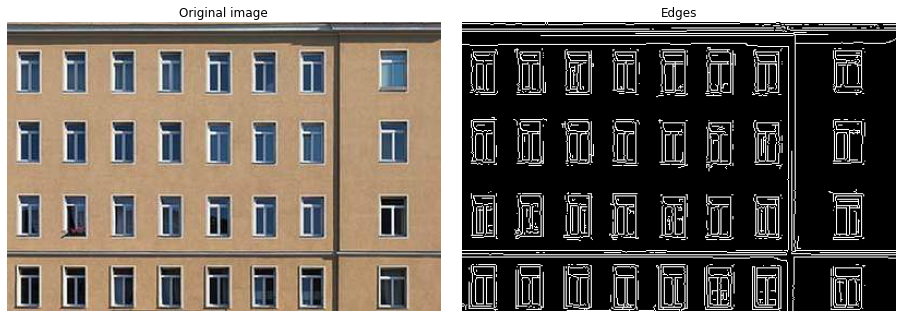

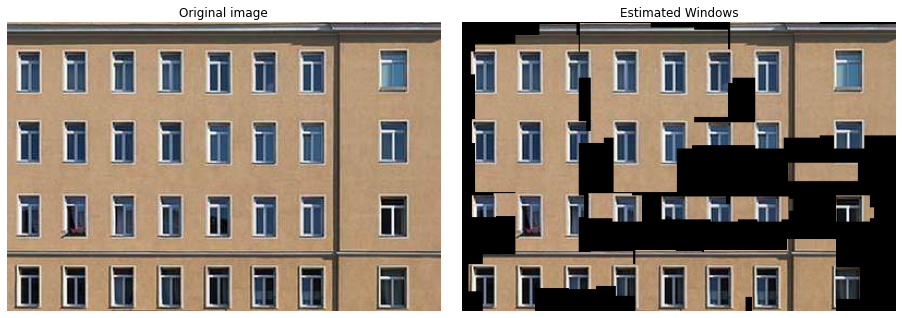

In [87]:
image = cv2.imread('Images/image_5.jpeg')

edges = apply_edge_detection(image)

display(image, edges, 'Original image', 'Edges')

horizontal_segments, vertical_segments = extract_segment_primitives(edges)


window_segments = window_segment(horizontal_segments, vertical_segments)
window_scores = calculate_score(window_segments)
window_img = construct_estimate_window_image(
    image, horizontal_segments, vertical_segments, window_segments, window_scores)

display(image, window_img, 'Original image', 'Estimated Windows')


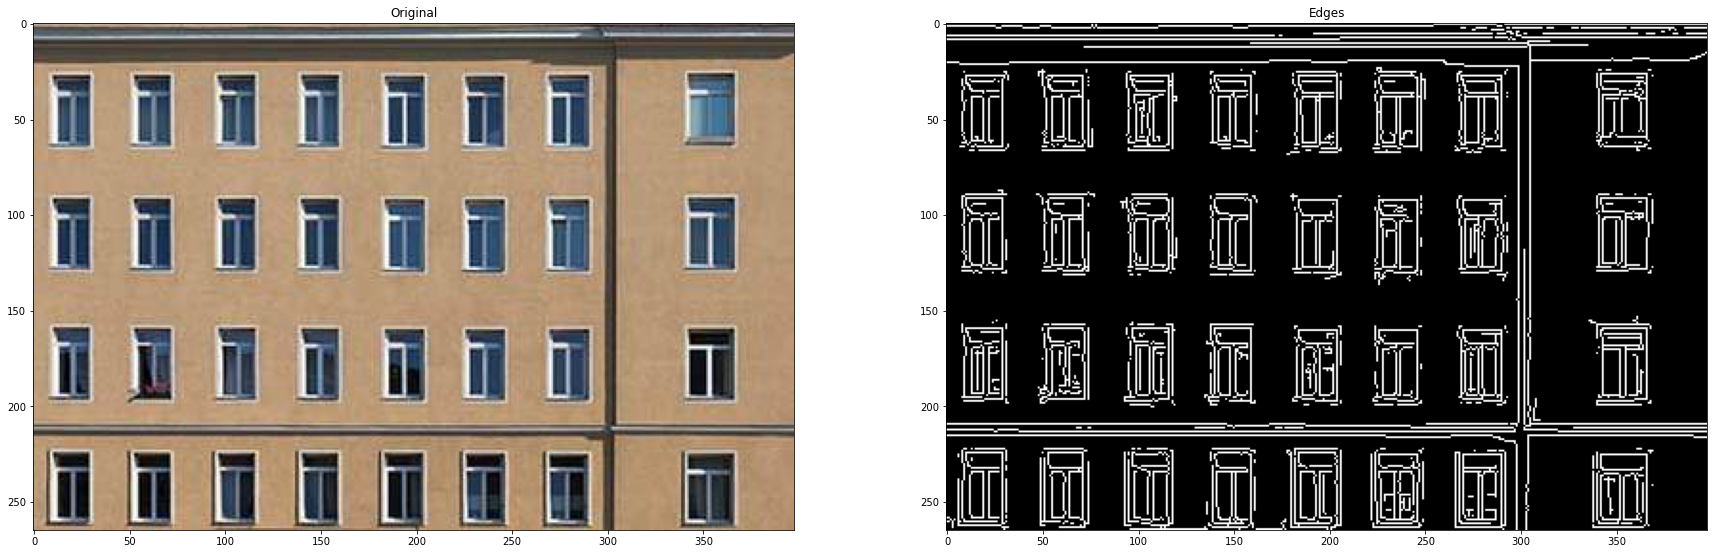

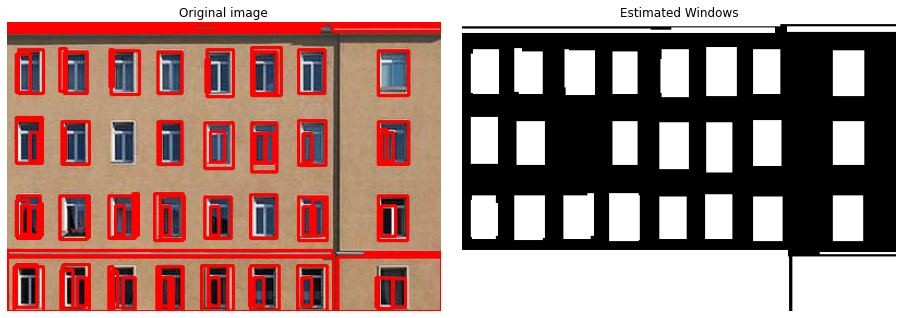

In [88]:


def score_window(img_edges, window):
    x1, y1, x2, y2 = window
    window_edges = img_edges[y1:y2, x1:x2]
    window_area = (x2 - x1) * (y2 - y1)
    score = np.sum(window_edges) / window_area
    return score


# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20))

# Display original image and edges
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title("Original")
ax2.imshow(edges, cmap="gray")
ax2.set_title("Edges")
# Show plot
plt.show()


primitives, img_windows = extract_segment_primitives_(edges, image)

black_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    # Draw a rectangle around the segment primitive
    # Add the vertical or horizontal segment primitive if the width or height is greater than a threshold
    if w > 50 and h < 100:

        # Draw a rectangle around the segment primitive
        cv2.rectangle(black_img, (x, y), (x+w, y+h), (255, 255, 255), -1)

    elif h > 25 and w < 30:
        # Draw a rectangle around the segment primitive
        cv2.rectangle(black_img, (x, y), (x+w, y+h), (255, 255, 255), -1)

display(image, black_img, 'Original image', 'Estimated Windows')
